In [ ]:
# ---------------------------------------
# Imports & Device Configuration
# ---------------------------------------
# Standard libraries for file paths, image I/O, and numeric ops
import os
import cv2 # for face detection & image processing
import numpy as np # numerical operations

# PyTorch core: tensor ops, neural nets, training
import torch
import torch.nn as nn
import torch.optim as optim

# PyTorch utilities for batching & vision models
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms, datasets

# For plotting results
import matplotlib.pyplot as plt

# Scikit-learn for cross-validation & metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,accuracy_score, ConfusionMatrixDisplay,
    classification_report, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    mean_squared_error
)
from sklearn.preprocessing import label_binarize

# PIL for easy array↔image conversion
from PIL import Image

In [ ]:
# Select Apple MPS (Metal GPU) if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [ ]:
# ---------------------------------------
# Face-Cropped Dataset Definition
# ---------------------------------------
# Custom Dataset that:
#  1) Loads images via ImageFolder
#  2) Detects & crops the first face with OpenCV Haar cascade
#  3) Applies any torchvision transforms
class FaceCroppedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Wrap an ImageFolder under the hood
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        # Haar cascade XML file for frontal-face detection
        self.face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image & label
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)

        # Convert to grayscale for face detection
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        # Crop first detected face, or fallback to full image
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = image[y:y+h, x:x+w]
        else:
            face = image  # fallback if no face detected

        # Convert BGR→RGB and to PIL for transforms
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)

        # Apply any augmentations / normalization
        if self.transform:
            face = self.transform(face)

        return face, label

In [ ]:
# ---------------------------------------
# Data Transforms & Test Loader
# ---------------------------------------
# Train-time augmentations: random crop, flip, rotation, color jitter, normalize
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Test/validation transforms: resize + normalize (no randomness)
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# -----------------------------------------------
# TunedEfficientNetB0 Model Definition
# -----------------------------------------------
# Loads EfficientNet-B0 pretrained on ImageNet and
# replaces its classifier head with a custom MLP.
class TunedEfficientNetB0(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_rate):
        super().__init__()
        # Backbone: EfficientNet-B0 with default ImageNet weights
        self.backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT
        )

        # Determine incoming feature dimension from original head
        #    effnet.classifier is [Dropout, Linear(in_features, 1000)]
        in_features = self.backbone.classifier[1].in_features

        # New classifier head:
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),               # regularization
            nn.Linear(in_features, hidden_size),    # compress to hidden_size
            nn.ReLU(inplace=True),                  # non-linear activation
            nn.Dropout(dropout_rate),               # more regularization
            nn.Linear(hidden_size, num_classes)     # final logits
        )

    def forward(self, x):
        # Delegate forward pass to the EfficientNet backbone
        return self.backbone(x)

In [ ]:
# -------------------------------
# Training / Validation Helpers
# -------------------------------
def train_one_epoch(model, optimizer, criterion, loader, device):
    """
    Performs one full epoch of training:
      - model.train()
      - zero_grad, forward, loss.backward, optimizer.step
      - accumulates running loss & accuracy
    Returns: (epoch_loss, epoch_accuracy)
    """
    model.train()
    running_loss = correct = total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def validate_model(model, criterion, loader, device):
    """
    Evaluates the model on a validation/test loader:
      - model.eval()
      - no_grad()
      - accumulates loss, accuracy, predictions & probabilities
    Returns: (loss, accuracy, preds_list, labels_list, probs_list)
    """
    model.eval()
    running_loss = correct = total = 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(out, dim=1).cpu().numpy())
    return (running_loss/total, correct/total, all_preds, all_labels, all_probs)

In [ ]:
# ---------------------------------------------------
# Pipeline Function – CV, Final Train & Metrics
# ---------------------------------------------------
def run_pipeline(
    data_dir,
    hyperparams,
    subset_ratio=0.3,
    cv_splits=5,
    num_epochs_cv=5,
    num_epochs_full=5,
    batch_size=32
):
    """
    Complete training pipeline:
    1) Builds CV subset and runs StratifiedKFold
    2) Reports per-fold and average CV accuracy/loss
    3) Trains on full training set for num_epochs_full
       while plotting train vs. test curves each epoch
    4) Final evaluation: confusion matrix + all core metrics
    Returns: trained model_final, test_transform, class_names
    """
    print(f"\n=== Dataset: {data_dir} ===")
    # -------------------------------
    # Data loaders
    # -------------------------------
    test_ds     = FaceCroppedDataset(os.path.join(data_dir, "test"),  transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    full_train_ds = FaceCroppedDataset(os.path.join(data_dir, "train"), transform=train_transform)

    # -------------------------------
    # Prepare CV subset
    # -------------------------------
    n_sub = int(len(full_train_ds) * subset_ratio)
    np.random.seed(42)
    idxs = np.random.choice(len(full_train_ds), n_sub, replace=False)
    cv_ds     = Subset(full_train_ds, idxs)
    cv_labels = [full_train_ds.dataset.samples[i][1] for i in idxs]

    # -------------------------------
    # Cross-validation
    # -------------------------------
    skf         = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    fold_losses = []
    fold_accs   = []

    for fold, (train_idx, val_idx) in enumerate(
        skf.split(np.zeros(len(cv_ds)), cv_labels), 1
    ):
        print(f"\n-- Fold {fold}/{cv_splits} --")
        tr_sub = Subset(cv_ds, train_idx)
        vl_sub = Subset(cv_ds, val_idx)
        tr_loader = DataLoader(tr_sub, batch_size=batch_size, shuffle=True)
        vl_loader = DataLoader(vl_sub, batch_size=batch_size, shuffle=False)

        # Instantiate a fresh model & optimizer per fold
        model = TunedEfficientNetB0(
            num_classes=len(full_train_ds.dataset.classes),
            hidden_size=hyperparams["hidden_size"],
            dropout_rate=hyperparams["dropout_rate"]
        ).to(device)

        # Choose optimizer type
        opt_name = hyperparams["optimizer"].lower()
        if opt_name == "adam":
            optimizer_cv = optim.Adam(model.parameters(), lr=hyperparams["lr"])
        elif opt_name == "sgd":
            optimizer_cv = optim.SGD(model.parameters(), lr=hyperparams["lr"], momentum=0.9)
        else:
            raise ValueError(f"Unsupported optimizer: {opt_name}")

        criterion = nn.CrossEntropyLoss()

        # Train & validate for num_epochs_cv
        for ep in range(1, num_epochs_cv + 1):
            tr_loss, tr_acc = train_one_epoch(model, optimizer_cv, criterion, tr_loader, device)
            vl_loss, vl_acc, *_ = validate_model(model, criterion, vl_loader, device)
            print(
                f"Epoch {ep}/{num_epochs_cv} — "
                f"Train: {tr_loss:.4f}/{tr_acc:.4f}, "
                f"Val:   {vl_loss:.4f}/{vl_acc:.4f}"
            )

        print(f"Fold {fold} Validation Accuracy: {vl_acc:.4f}")
        fold_losses.append(vl_loss)
        fold_accs.append(vl_acc)

    # CV summary
    avg_loss = np.mean(fold_losses)
    avg_acc  = np.mean(fold_accs)
    print("\nCross-Validation Results per Fold:")
    for i, acc in enumerate(fold_accs, 1):
        print(f"  Fold {i}: {acc:.4f}")
    print(f"Average CV Loss:     {avg_loss:.4f}")
    print(f"Average CV Accuracy: {avg_acc:.4f}\n\n")

    # -------------------------------
    # Final training on full train set
    # -------------------------------
    full_loader = DataLoader(full_train_ds, batch_size=batch_size, shuffle=True)
    model_final = TunedEfficientNetB0(
        num_classes=len(full_train_ds.dataset.classes),
        hidden_size=hyperparams["hidden_size"],
        dropout_rate=hyperparams["dropout_rate"]
    ).to(device)

    # Final optimizer
    opt_name = hyperparams["optimizer"].lower()
    if opt_name == "adam":
        optimizer = optim.Adam(model_final.parameters(), lr=hyperparams["lr"])
    elif opt_name == "sgd":
        optimizer = optim.SGD(model_final.parameters(), lr=hyperparams["lr"], momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {opt_name}")

    criterion = nn.CrossEntropyLoss()

    # -------------------------------
    # Train & test curves each epoch
    # -------------------------------
    history = {
        "train_loss": [], "train_acc": [],
        "test_loss":  [], "test_acc":  []
    }

    for ep in range(1, num_epochs_full + 1):
        tr_loss, tr_acc   = train_one_epoch(model_final, optimizer, criterion, full_loader, device)
        te_loss, te_acc, *_ = validate_model(model_final, criterion, test_loader, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)

        print(
            f"Full Train Epoch {ep}/{num_epochs_full} — "
            f"Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | "
            f"Test Loss:  {te_loss:.4f}, Test Acc:  {te_acc:.4f}"
        )

    # Plot: Train vs Test Loss
    epochs = range(1, num_epochs_full + 1)
    plt.figure()
    plt.plot(epochs, history["train_loss"], marker='o', label="Train Loss", color="green")
    plt.plot(epochs, history["test_loss"],  marker='o', label="Test Loss",  color="yellow")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Train vs Test Loss"); plt.legend(); plt.show()

    # Plot: Train vs Test Accuracy
    plt.figure()
    plt.plot(epochs, history["train_acc"], marker='o', label="Train Acc", color="green")
    plt.plot(epochs, history["test_acc"],  marker='o', label="Test Acc",  color="yellow")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Train vs Test Accuracy"); plt.legend(); plt.show()

    # -------------------------------
    # Final evaluation on test set
    # -------------------------------
    _, _, preds, labels, probs = validate_model(model_final, criterion, test_loader, device)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=full_train_ds.dataset.classes)
    disp.plot(cmap="Reds"); plt.title("Test Confusion Matrix"); plt.show()

    # -------------------------------
    # Compute and print metrics
    # -------------------------------
    accuracy  = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall    = recall_score(labels, preds, average="macro")
    f1        = f1_score(labels, preds, average="macro")

    print(f"Accuracy:          {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro):    {recall:.4f}")
    print(f"F1 Score (Macro):  {f1:.4f}")

    # ROC-AUC & PR-AUC
    labels_bin = label_binarize(labels, classes=range(len(full_train_ds.dataset.classes)))
    roc_auc    = roc_auc_score(labels_bin, probs, average="macro", multi_class="ovr")
    pr_auc     = average_precision_score(labels_bin, probs, average="macro")

    print(f"ROC-AUC:           {roc_auc:.4f}")
    print(f"PR-AUC:            {pr_auc:.4f}")

    # RMSE
    mse  = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    print(f"RMSE:              {rmse:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(labels, preds, target_names=full_train_ds.dataset.classes))

    # Return trained model + transform + class names
    return model_final, test_transform, full_train_ds.dataset.classes

In [9]:
# prepare face detector once
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [ ]:
# ---------------------------------------
# Prediction Utility
# ---------------------------------------
# Detects faces in an image, crops, transforms & predicts emotion.
def predict_faces_in_image(image_path, model, transform, class_names):
    # 1) Read & copy for annotation
    img = cv2.imread(image_path)
    out_img = img.copy()

    # 2) Face detection on grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        print("No faces detected.")
        return

    model.eval()
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = Image.fromarray(face)
        tensor = transform(face).unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(tensor)
            pred = out.argmax(dim=1).item()
            label = class_names[pred]

        # Draw box & label
        cv2.rectangle(out_img, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(out_img, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    # Display with matplotlib (RGB)
    rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(rgb); plt.axis("off"); plt.title("Predicted Emotions")
    plt.show()

In [11]:
# -------------------------------
# Hyperparameters
# -------------------------------
hyperparams_raf = {
    "hidden_size":   256,
    "dropout_rate":  0.4,
    "lr":            0.001,
    "optimizer":    "adam"
}
hyperparams_fer = {
    "hidden_size":   256,
    "dropout_rate":  0.3,
    "lr":            0.0001,
    "optimizer":    "adam"
}


=== Dataset: RAF-DB ===

-- Fold 1/5 --
Epoch 1/5 — Train: 1.2344/0.5390, Val:   0.9742/0.6499
Epoch 2/5 — Train: 0.8862/0.6869, Val:   0.8611/0.7046
Epoch 3/5 — Train: 0.7576/0.7287, Val:   0.7608/0.7478
Epoch 4/5 — Train: 0.6798/0.7561, Val:   0.7179/0.7277
Epoch 5/5 — Train: 0.5531/0.8070, Val:   0.7136/0.7478
Fold 1 Validation Accuracy: 0.7478

-- Fold 2/5 --
Epoch 1/5 — Train: 1.2873/0.5117, Val:   1.1486/0.5830
Epoch 2/5 — Train: 0.9129/0.6733, Val:   0.9023/0.6797
Epoch 3/5 — Train: 0.7426/0.7364, Val:   0.8857/0.6898
Epoch 4/5 — Train: 0.6768/0.7663, Val:   0.7512/0.7431
Epoch 5/5 — Train: 0.5851/0.8035, Val:   0.7431/0.7504
Fold 2 Validation Accuracy: 0.7504

-- Fold 3/5 --
Epoch 1/5 — Train: 1.2524/0.5261, Val:   1.0958/0.6421
Epoch 2/5 — Train: 0.8885/0.6780, Val:   0.8980/0.6724
Epoch 3/5 — Train: 0.7274/0.7371, Val:   0.7723/0.7157
Epoch 4/5 — Train: 0.6555/0.7670, Val:   0.7938/0.7186
Epoch 5/5 — Train: 0.5714/0.7955, Val:   0.9109/0.7244
Fold 3 Validation Accuracy: 0.72

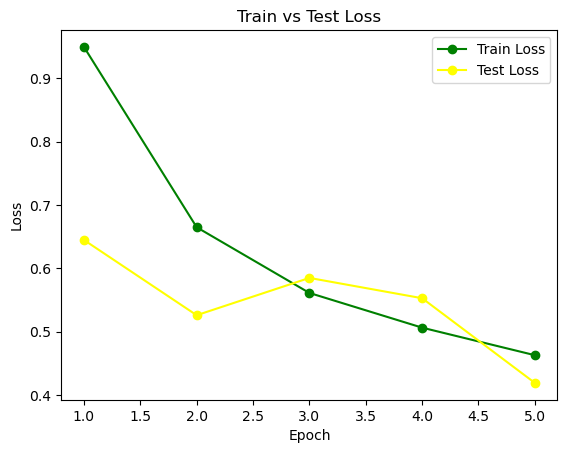

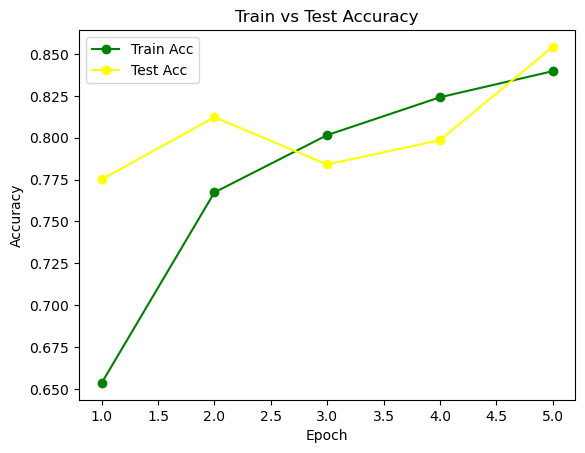

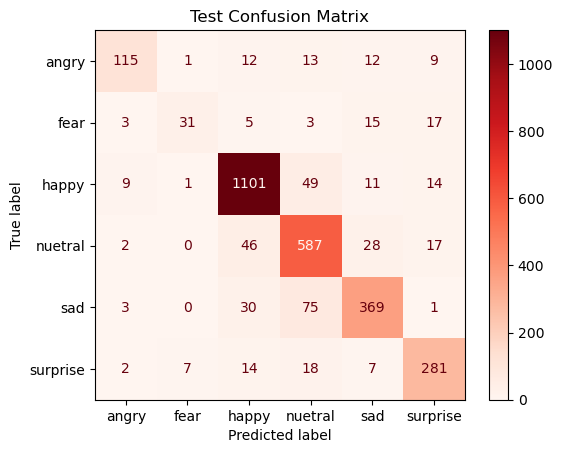

Accuracy:          0.8542
Precision (Macro): 0.8327
Recall (Macro):    0.7579
F1 Score (Macro):  0.7847
ROC-AUC:           0.9729
PR-AUC:            0.8686
RMSE:              0.8369

Classification Report:

              precision    recall  f1-score   support

       angry       0.86      0.71      0.78       162
        fear       0.78      0.42      0.54        74
       happy       0.91      0.93      0.92      1185
     nuetral       0.79      0.86      0.82       680
         sad       0.83      0.77      0.80       478
    surprise       0.83      0.85      0.84       329

    accuracy                           0.85      2908
   macro avg       0.83      0.76      0.78      2908
weighted avg       0.85      0.85      0.85      2908



In [12]:
# -------------------------------
# Run for RAF-DB
# -------------------------------
model_raf, test_transform, raf_classes = run_pipeline("RAF-DB",  hyperparams_raf,  subset_ratio=0.3,
             cv_splits=5, num_epochs_cv=5, num_epochs_full=5, batch_size=32)

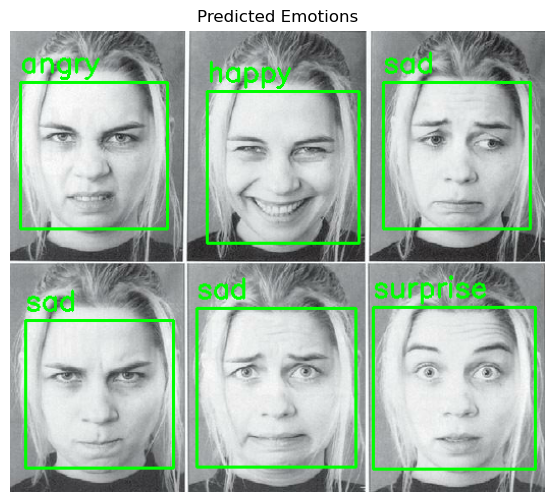

In [13]:
# -------------------------------
# Predict with RAF-DB Model
# -------------------------------
predict_faces_in_image("test.png", model_raf, test_transform, raf_classes)


=== Dataset: FER-2013 ===

-- Fold 1/5 --
Epoch 1/5 — Train: 1.5927/0.3488, Val:   1.3878/0.4443
Epoch 2/5 — Train: 1.3169/0.4813, Val:   1.1983/0.5468
Epoch 3/5 — Train: 1.1726/0.5463, Val:   1.1229/0.5645
Epoch 4/5 — Train: 1.0565/0.5985, Val:   1.0468/0.6005
Epoch 5/5 — Train: 0.9739/0.6287, Val:   1.0629/0.6034
Fold 1 Validation Accuracy: 0.6034

-- Fold 2/5 --
Epoch 1/5 — Train: 1.5748/0.3630, Val:   1.3775/0.4475
Epoch 2/5 — Train: 1.2924/0.4985, Val:   1.1962/0.5318
Epoch 3/5 — Train: 1.1427/0.5620, Val:   1.1300/0.5513
Epoch 4/5 — Train: 1.0360/0.6052, Val:   1.0569/0.5908
Epoch 5/5 — Train: 0.9475/0.6436, Val:   1.0522/0.6050
Fold 2 Validation Accuracy: 0.6050

-- Fold 3/5 --
Epoch 1/5 — Train: 1.5975/0.3436, Val:   1.3836/0.4558
Epoch 2/5 — Train: 1.3016/0.4952, Val:   1.1880/0.5366
Epoch 3/5 — Train: 1.1452/0.5602, Val:   1.0754/0.5831
Epoch 4/5 — Train: 1.0400/0.6074, Val:   1.0209/0.6050
Epoch 5/5 — Train: 0.9481/0.6410, Val:   1.0112/0.6038
Fold 3 Validation Accuracy: 0.

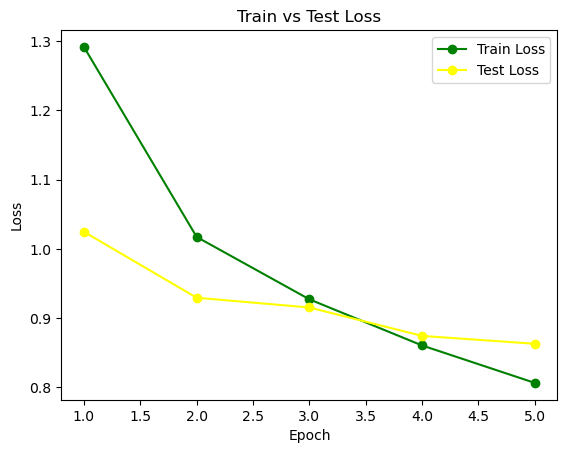

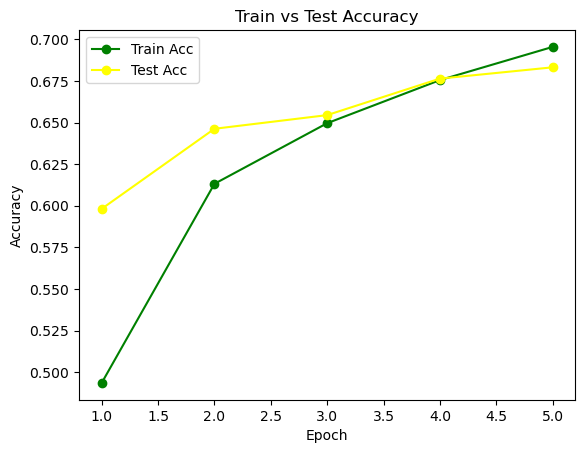

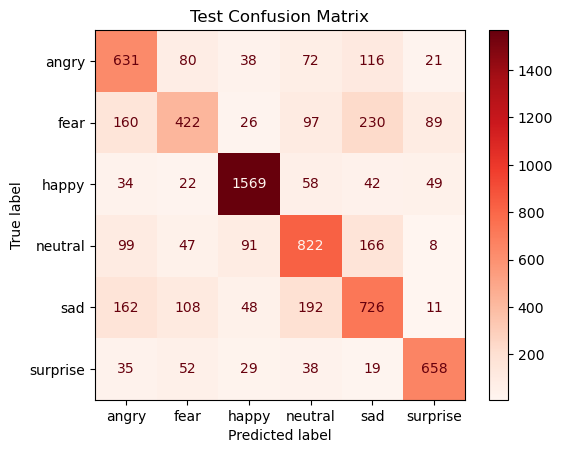

Accuracy:          0.6832
Precision (Macro): 0.6667
Recall (Macro):    0.6660
F1 Score (Macro):  0.6633
ROC-AUC:           0.9147
PR-AUC:            0.7208
RMSE:              1.4867

Classification Report:

              precision    recall  f1-score   support

       angry       0.56      0.66      0.61       958
        fear       0.58      0.41      0.48      1024
       happy       0.87      0.88      0.88      1774
     neutral       0.64      0.67      0.65      1233
         sad       0.56      0.58      0.57      1247
    surprise       0.79      0.79      0.79       831

    accuracy                           0.68      7067
   macro avg       0.67      0.67      0.66      7067
weighted avg       0.68      0.68      0.68      7067



In [14]:
# -------------------------------
# Run for FER-2013
# -------------------------------
model_fer, test_transform, fer_classes = run_pipeline("FER-2013", hyperparams_fer, subset_ratio=0.3,
             cv_splits=5, num_epochs_cv=5, num_epochs_full=5, batch_size=32)

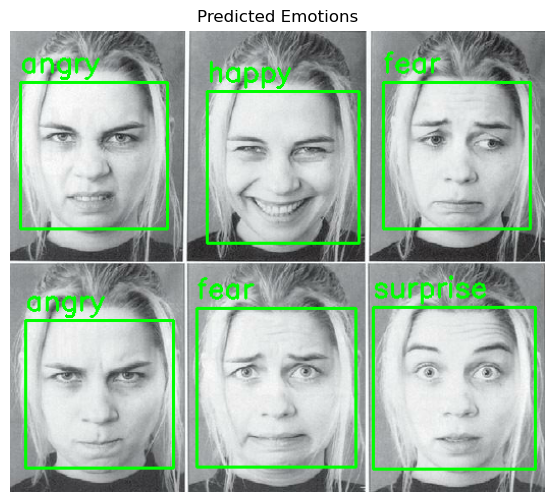

In [15]:
# -------------------------------
# Predict with FER-2013 Model
# -------------------------------
predict_faces_in_image("test.png", model_fer, test_transform, fer_classes)